In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
import numpy as np

# Data Understanding Section

## Loading the dataset and spark setup

In [2]:
spark = SparkSession.builder.appName("myapp").master('local[*]').getOrCreate()

24/12/03 17:26:54 WARN Utils: Your hostname, MacBook-Air-mba.local resolves to a loopback address: 127.0.0.1; using 192.168.1.211 instead (on interface en0)
24/12/03 17:26:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 17:26:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('dataset/Base.csv', header=True, inferSchema=True)

spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")

Here i'm checking how many cores are being used by spark

In [4]:
num_cores = spark.sparkContext.defaultParallelism
print(f"Spark is using {num_cores} cores.")

Spark is using 8 cores.


## Exploring the dataset

In [5]:
df.show()

24/12/03 16:50:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_month

In [6]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobil

## Get the number of unique values in each column of the DataFrame

In [7]:
for col_name in df.columns:
    print(f"The column '{col_name}' has {df.select(col_name).distinct().count()} unique values.")

The column 'fraud_bool' has 2 unique values.


The column 'income' has 9 unique values.


The column 'name_email_similarity' has 998861 unique values.


The column 'prev_address_months_count' has 374 unique values.
The column 'current_address_months_count' has 423 unique values.
The column 'customer_age' has 9 unique values.


The column 'days_since_request' has 989330 unique values.


24/12/03 16:50:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


The column 'intended_balcon_amount' has 994971 unique values.
The column 'payment_type' has 5 unique values.


The column 'zip_count_4w' has 6306 unique values.


The column 'velocity_6h' has 998687 unique values.


The column 'velocity_24h' has 998940 unique values.


The column 'velocity_4w' has 998318 unique values.


The column 'bank_branch_count_8w' has 2326 unique values.
The column 'date_of_birth_distinct_emails_4w' has 40 unique values.
The column 'employment_status' has 7 unique values.
The column 'credit_risk_score' has 551 unique values.
The column 'email_is_free' has 2 unique values.
The column 'housing_status' has 7 unique values.
The column 'phone_home_valid' has 2 unique values.
The column 'phone_mobile_valid' has 2 unique values.
The column 'bank_months_count' has 33 unique values.
The column 'has_other_cards' has 2 unique values.
The column 'proposed_credit_limit' has 12 unique values.
The column 'foreign_request' has 2 unique values.
The column 'source' has 2 unique values.


The column 'session_length_in_minutes' has 994887 unique values.
The column 'device_os' has 5 unique values.
The column 'keep_alive_session' has 2 unique values.
The column 'device_distinct_emails_8w' has 4 unique values.
The column 'device_fraud_count' has 1 unique values.
The column 'month' has 8 unique values.


In [8]:
df.describe()

DataFrame[summary: string, fraud_bool: string, income: string, name_email_similarity: string, prev_address_months_count: string, current_address_months_count: string, customer_age: string, days_since_request: string, intended_balcon_amount: string, payment_type: string, zip_count_4w: string, velocity_6h: string, velocity_24h: string, velocity_4w: string, bank_branch_count_8w: string, date_of_birth_distinct_emails_4w: string, employment_status: string, credit_risk_score: string, email_is_free: string, housing_status: string, phone_home_valid: string, phone_mobile_valid: string, bank_months_count: string, has_other_cards: string, proposed_credit_limit: string, foreign_request: string, source: string, session_length_in_minutes: string, device_os: string, keep_alive_session: string, device_distinct_emails_8w: string, device_fraud_count: string, month: string]

## Looking for missing values

In [9]:
#Check if there are any missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+-----------+------------+-----------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|velocity_6h|velocity_24h|velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|proposed_credit_limit|foreign_request|sour

There are no missing values in the dataset

## Checking the data types and values of the columns

In [10]:
#Check for outliers
df.describe().show()

+-------+-------------------+-------------------+---------------------+-------------------------+----------------------------+------------------+--------------------+----------------------+------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------------------+-----------------+-----------------+------------------+--------------+------------------+-------------------+------------------+-------------------+---------------------+-------------------+--------+-------------------------+---------+-------------------+-------------------------+------------------+------------------+
|summary|         fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|      customer_age|  days_since_request|intended_balcon_amount|payment_type|      zip_count_4w|        velocity_6h|      velocity_24h|      velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_statu

## Looking at the distribution of the target variable 'fraud_bool'

In [11]:
#Distribution of the target variable 'fraud_bool'
df.groupBy('fraud_bool').count().show()

#Print the distribution in percentage
df.groupBy('fraud_bool').count().withColumn('percentage', col('count') / df.count() * 100).show()

+----------+------+
|fraud_bool| count|
+----------+------+
|         1| 11029|
|         0|988971|
+----------+------+

+----------+------+-----------------+
|fraud_bool| count|       percentage|
+----------+------+-----------------+
|         1| 11029|           1.1029|
|         0|988971|98.89710000000001|
+----------+------+-----------------+



The dataset is, as expected, highly imbalanced towards the non-fraudulent transactions. This is a common issue in fraud detection problems, and we will need to address it later on.

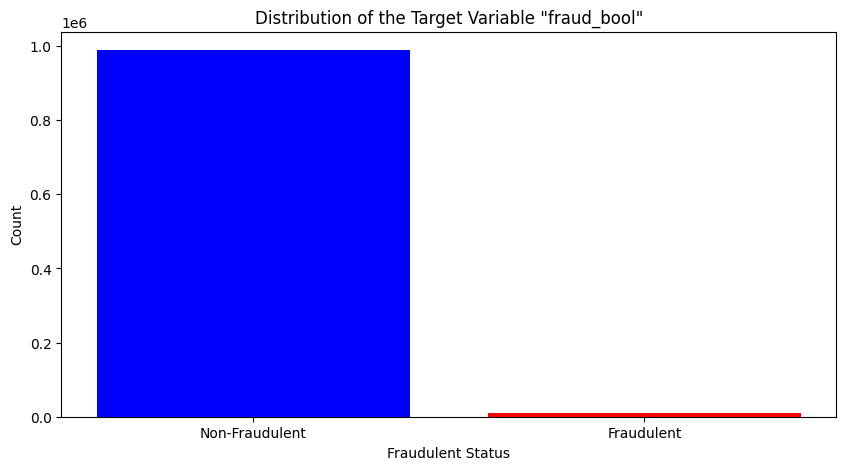

In [12]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Compute the distribution of the 'fraud_bool' column
fraud_distribution = (
    df.groupBy("fraud_bool")
    .count()
    .orderBy("fraud_bool")
)

# Collect the data for the plot
plot_data = fraud_distribution.collect()

# Extract labels and counts
labels = ["Non-Fraudulent", "Fraudulent"]
values = [row["count"] for row in plot_data]

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=["blue", "red"])
plt.title('Distribution of the Target Variable "fraud_bool"')
plt.ylabel("Count")
plt.xlabel("Fraudulent Status")
plt.xticks(rotation=0)
plt.show()

## Looking at the distribution of the Income Value

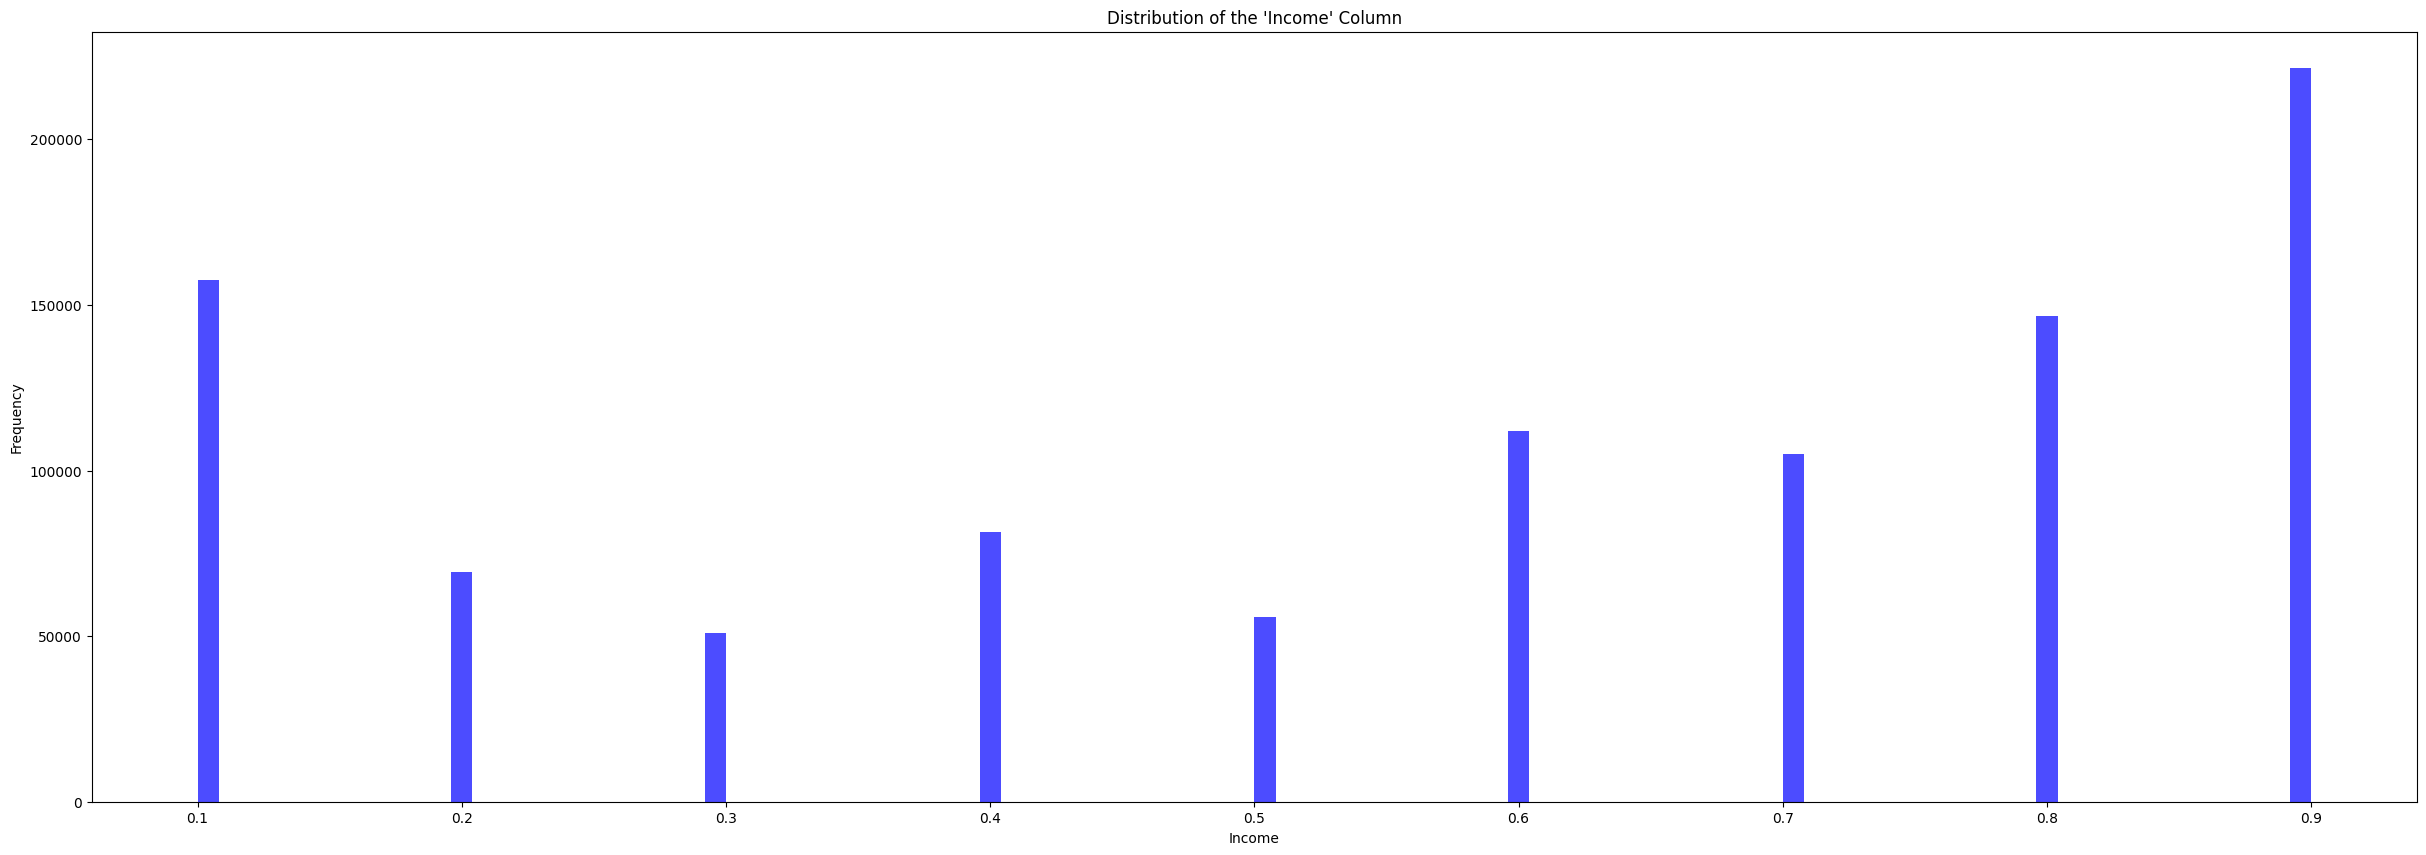

In [13]:
import matplotlib.pyplot as plt

# Compute the distribution of the 'income' column
# (No need to aggregate since we're plotting the histogram)
income_values = df.select("income").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(30, 10))
plt.hist(income_values, bins=100, color='blue', alpha=0.7)
plt.title("Distribution of the 'Income' Column")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

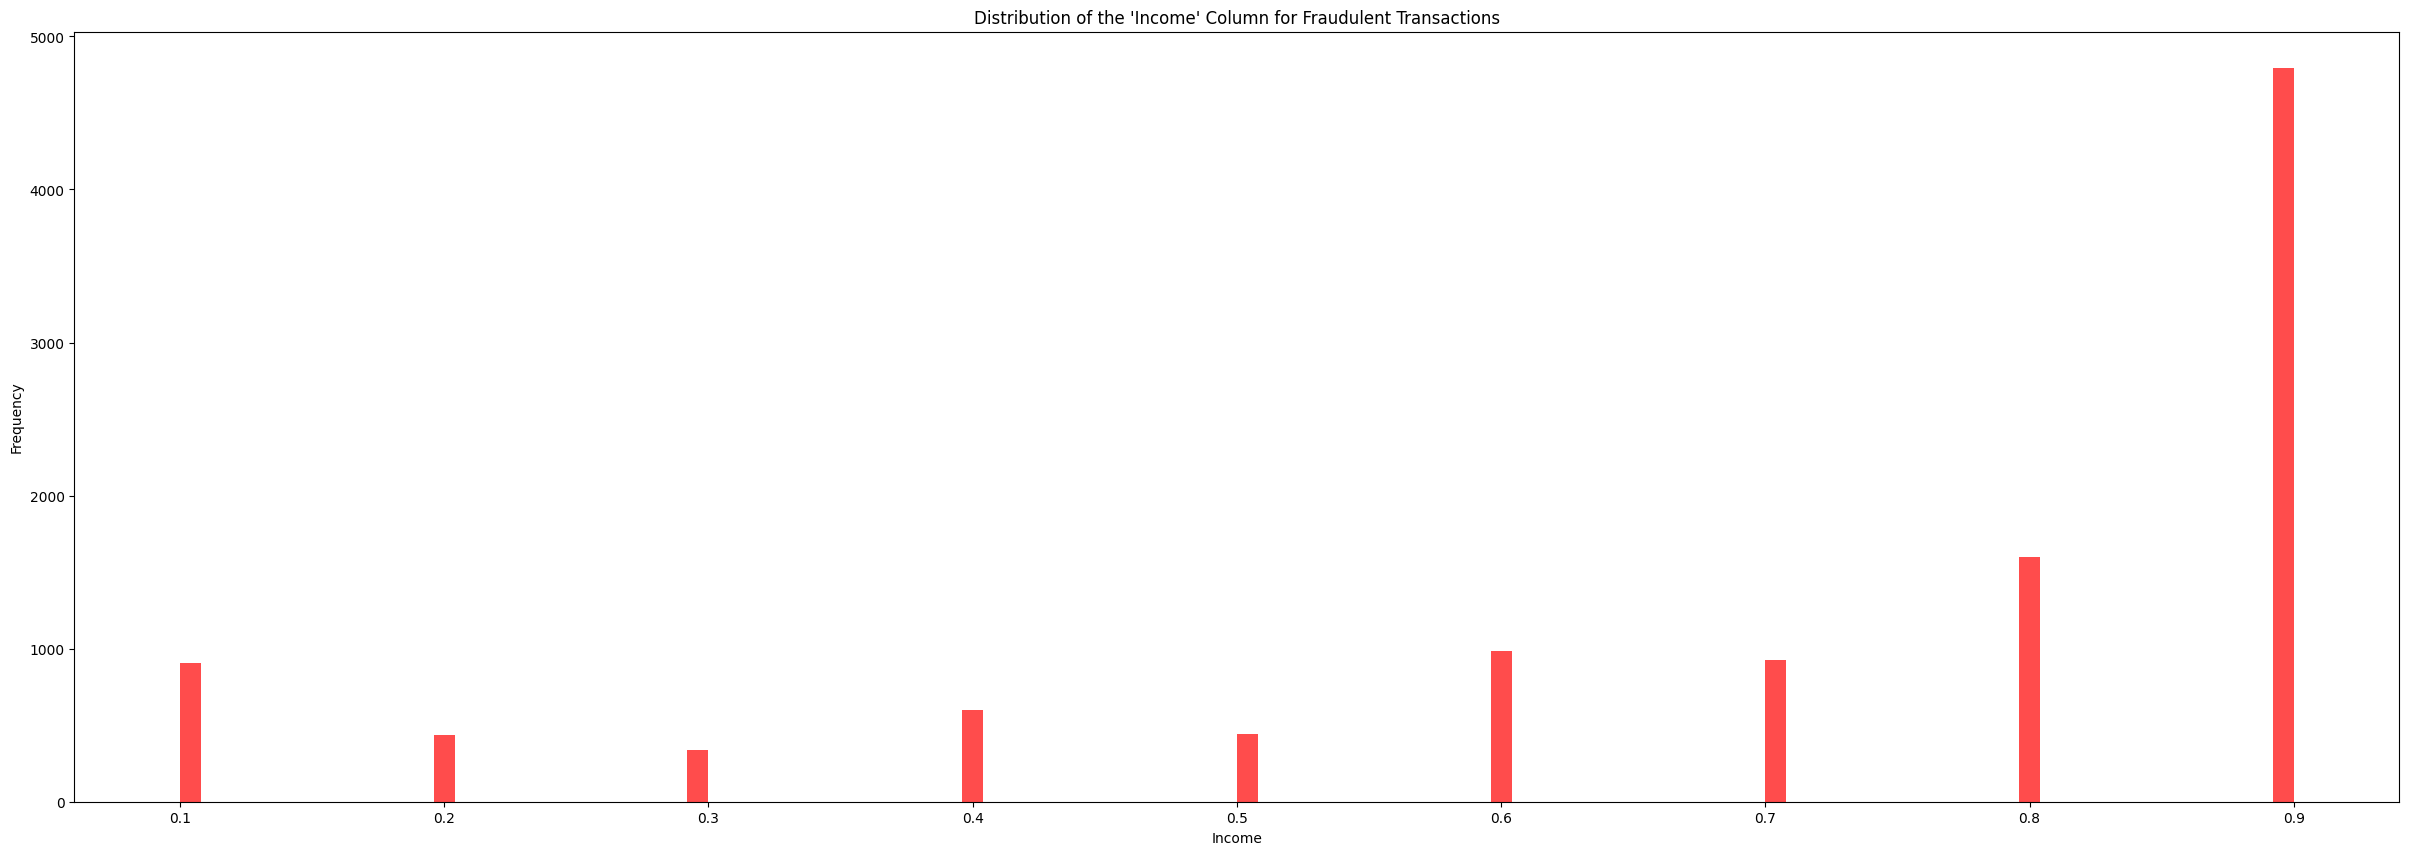

In [14]:
import matplotlib.pyplot as plt

# Filter for fraudulent transactions (fraud_bool == 1)
fraudulent_income = df.filter(df["fraud_bool"] == 1).select("income")

# Extract income values as a list for plotting
income_values = fraudulent_income.rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(30, 10))
plt.hist(income_values, bins=100, color='red', alpha=0.7)
plt.title("Distribution of the 'Income' Column for Fraudulent Transactions")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

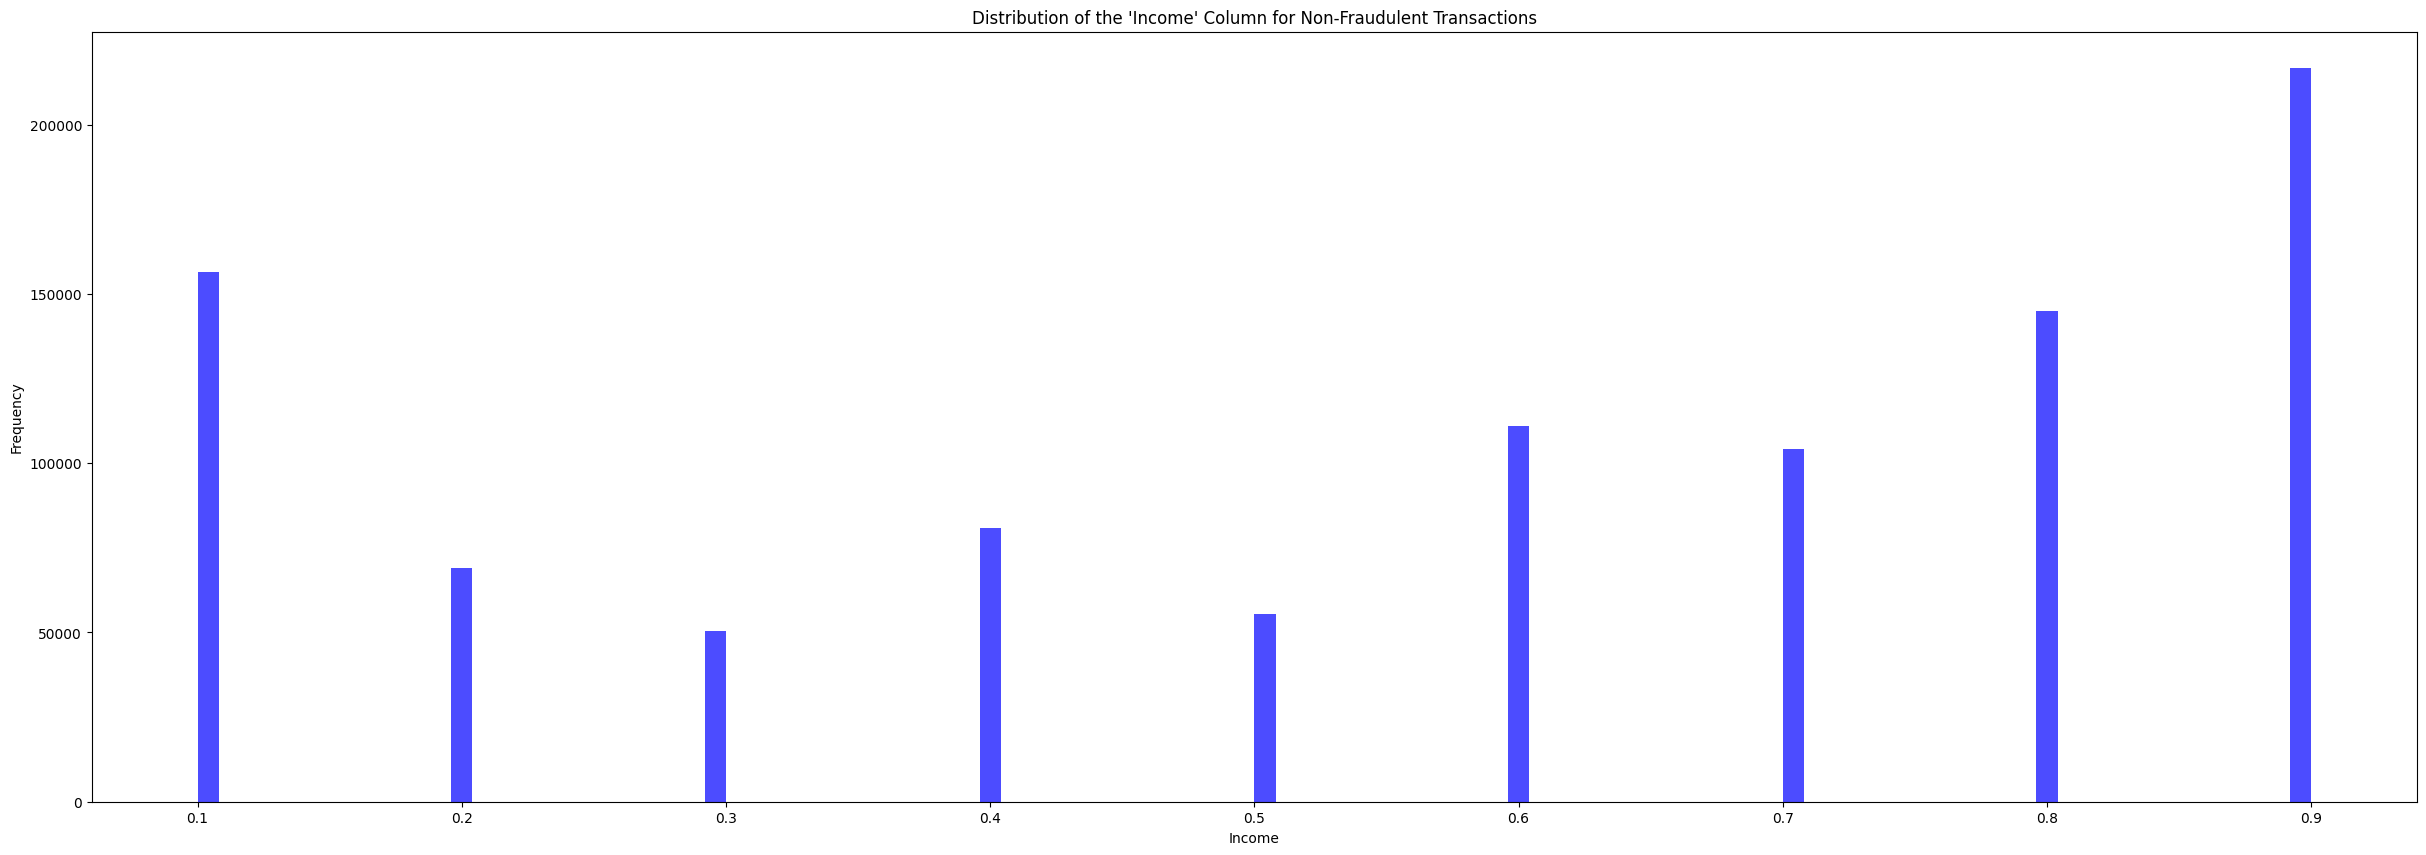

In [15]:
import matplotlib.pyplot as plt

# Filter for non-fraudulent transactions (fraud_bool == 0)
non_fraudulent_income = df.filter(df["fraud_bool"] == 0).select("income")

# Extract income values as a list for plotting
income_values = non_fraudulent_income.rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(30, 10))
plt.hist(income_values, bins=100, color='blue', alpha=0.7)
plt.title("Distribution of the 'Income' Column for Non-Fraudulent Transactions")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

## Correlation between Income, Age and Fraud count

In [16]:
# show distribution of income column in df
df.groupBy('income').count().show()

+------------------+------+
|            income| count|
+------------------+------+
|               0.2| 69345|
|               0.1|157449|
|               0.8|146650|
|               0.5| 55858|
|0.6000000000000001|111973|
|               0.4| 81364|
|               0.9|221419|
|               0.3| 50833|
|0.7000000000000001|105109|
+------------------+------+



We can notice that the fraudulent transactions applicants have a higher income value compared to the non-fraudulent transactions. 

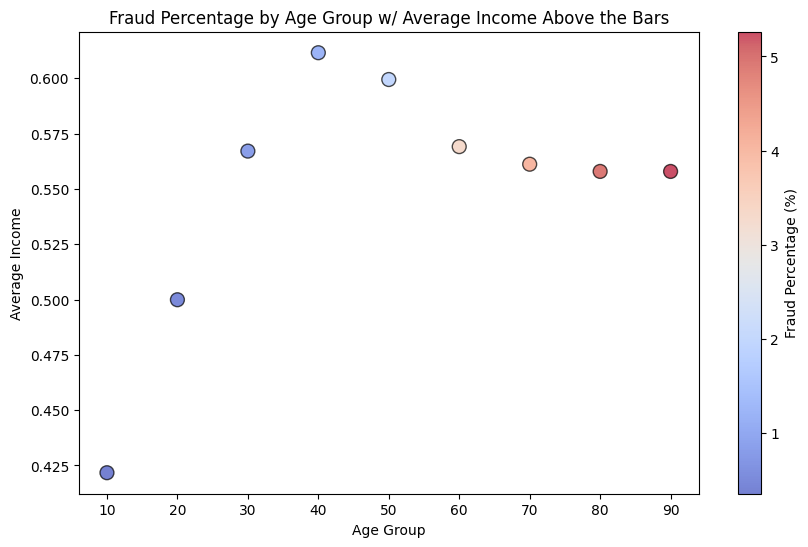

In [17]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Grouping by age and calculating metrics
age_group_summary = (
    df.groupBy("customer_age")
    .agg(
        F.mean("fraud_bool").alias("fraud_percentage"),
        F.mean("income").alias("average_income")
    )
    .orderBy("customer_age")  # order by age
)

# Convert fraud percentage to a 0-100 scale
age_group_summary = age_group_summary.withColumn("fraud_percentage", F.col("fraud_percentage") * 100)

# Collecting data for the plot
plot_data = age_group_summary.collect()

# extract data for the plot
age_groups = [row["customer_age"] for row in plot_data]
average_income = [row["average_income"] for row in plot_data]
fraud_percentage = [row["fraud_percentage"] for row in plot_data]

# Creating the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    age_groups,
    average_income,
    c=fraud_percentage,
    cmap="coolwarm",
    s=100,
    alpha=0.7,
    edgecolor='k'
)

# add labels
plt.colorbar(scatter, label="Fraud Percentage (%)")
plt.xlabel("Age Group")
plt.ylabel("Average Income")
plt.title("Fraud Percentage by Age Group w/ Average Income Above the Bars")
plt.show()

## Looking at the distribution of the Age Value

In [18]:
df.groupBy('customer_age').count().show()

+------------+------+
|customer_age| count|
+------------+------+
|          40|238712|
|          20|245855|
|          10| 20987|
|          50|140353|
|          80|  1297|
|          70|  6517|
|          60| 34770|
|          90|    76|
|          30|311433|
+------------+------+



We can see that the age values are not continuous, but discrete. This is because the age values are binned into ranges. Also the majority of the customers are in the age range of 20-40.

In [19]:
non_fraudulent_age = df.filter(df['fraud_bool'] == 0).groupBy('customer_age').count()
non_fraudulent_age = non_fraudulent_age.withColumn('percentage', (col('count') / df.filter(df['fraud_bool'] == 0).count()) * 100)
non_fraudulent_age = non_fraudulent_age.orderBy('percentage', ascending=False)
print("Non-Fraudulent Transactions by Customer Age:")
non_fraudulent_age.show()

Non-Fraudulent Transactions by Customer Age:
+------------+------+--------------------+
|customer_age| count|          percentage|
+------------+------+--------------------+
|          30|308844|  31.228822685397244|
|          20|244650|  24.737833566403868|
|          40|235836|  23.846604197696394|
|          50|137548|  13.908193465733575|
|          60| 33621|  3.3995941235890634|
|          10| 20913|   2.114622167889655|
|          70|  6254|  0.6323744578961366|
|          80|  1233| 0.12467504102749222|
|          90|    72|0.007280294366568889|
+------------+------+--------------------+



In [20]:
# Filter for fraudulent transactions, group by customer_age, count occurrences, and calculate percentage
fraudulent_age = df.filter(df['fraud_bool'] == 1).groupBy('customer_age').count()
fraudulent_age = fraudulent_age.withColumn('percentage', (col('count') / df.filter(df['fraud_bool'] == 1).count()) * 100)
fraudulent_age = fraudulent_age.orderBy('percentage', ascending=False)
print("Fraudulent Transactions by Customer Age:")
fraudulent_age.show()

Fraudulent Transactions by Customer Age:
+------------+-----+-------------------+
|customer_age|count|         percentage|
+------------+-----+-------------------+
|          40| 2876| 26.076706863722915|
|          50| 2805| 25.432949496781216|
|          30| 2589| 23.474476380451538|
|          20| 1205|   10.9257412276725|
|          60| 1149| 10.417988938253695|
|          70|  263|  2.384622359234745|
|          10|   74|  0.670958382446278|
|          80|   64| 0.5802883307643485|
|          90|    4|0.03626802067277178|
+------------+-----+-------------------+



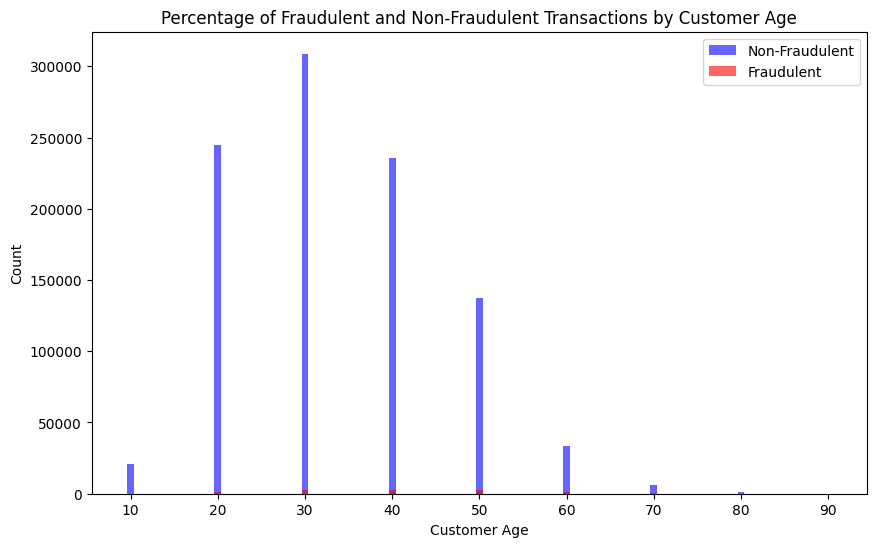

In [21]:
# Collect data for plotting
non_fraudulent_age_data = non_fraudulent_age.select('customer_age', 'count').collect()
fraudulent_age_data = fraudulent_age.select('customer_age', 'count').collect()

# Extract data for plotting
non_fraudulent_ages = [row['customer_age'] for row in non_fraudulent_age_data]
non_fraudulent_counts = [row['count'] for row in non_fraudulent_age_data]
fraudulent_ages = [row['customer_age'] for row in fraudulent_age_data]
fraudulent_counts = [row['count'] for row in fraudulent_age_data]

plt.figure(figsize=(10, 6))
plt.bar(non_fraudulent_ages, non_fraudulent_counts, color='blue', alpha=0.6, label='Non-Fraudulent')
plt.bar(fraudulent_ages, fraudulent_counts, color='red', alpha=0.6, label='Fraudulent')
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.title('Percentage of Fraudulent and Non-Fraudulent Transactions by Customer Age')
plt.legend()

plt.show()


From these data i think that we can say that there is a slight shift in fraudulent transactions towards the brackets 40 and 50 compared to non-fraudulent ones. The lower percentage of fraudulent transactions among young people like those in the 20 bracket could indicate more attention by the customers or maybe that having in general less money they tend to be less targeted by fraudsters. 

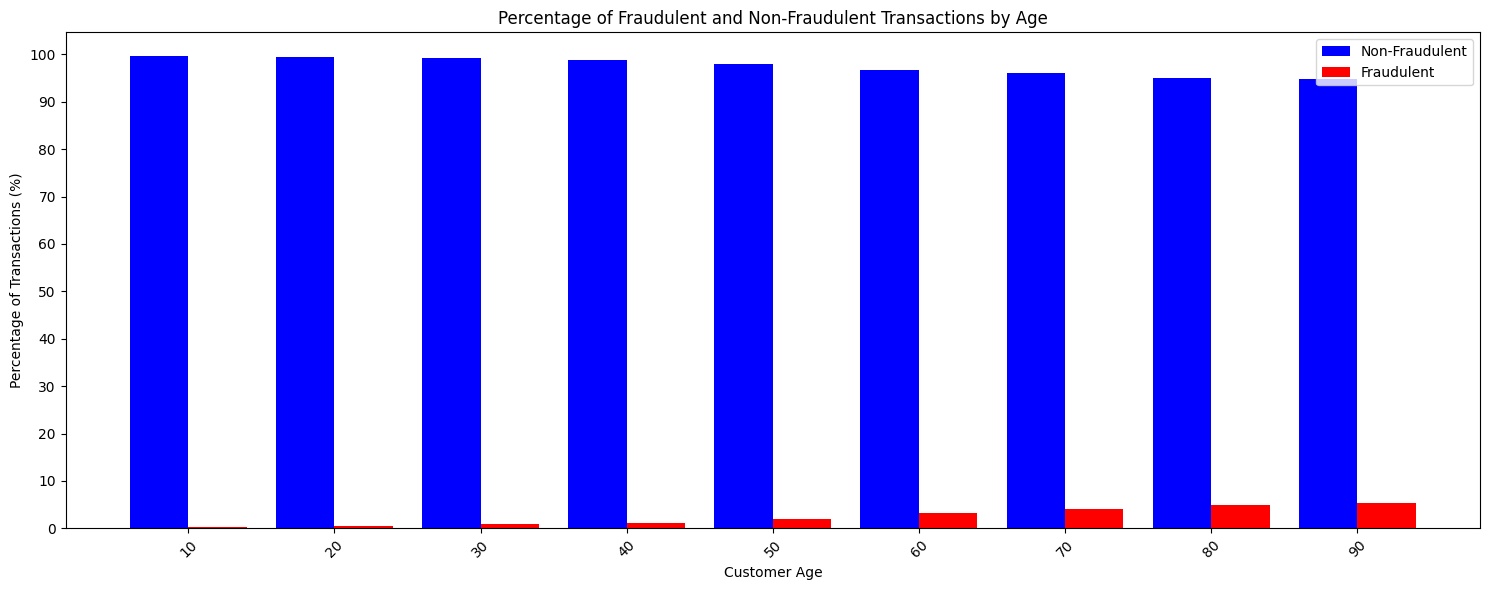

In [22]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Group by customer_age and calculate total transactions and fraud transactions
age_group = df.groupBy("customer_age").agg(
    F.count("*").alias("total_transactions"),
    F.sum("fraud_bool").alias("fraud_transactions")
)

# Calculate fraud and non-fraud percentages
age_group = age_group.withColumn(
    "fraud_percentage",
    (F.col("fraud_transactions") / F.col("total_transactions")) * 100
).withColumn(
    "non_fraud_percentage",
    100 - F.col("fraud_percentage")
)

# Collect data for plotting
plot_data = age_group.orderBy("customer_age").collect()

# Extract data for plotting
ages = [row["customer_age"] for row in plot_data]
fraud_percentages = [row["fraud_percentage"] for row in plot_data]
non_fraud_percentages = [row["non_fraud_percentage"] for row in plot_data]

# Plotting
plt.figure(figsize=(15, 6))

# Plot side-by-side bars
bar_width = 0.4
x = range(len(ages))

plt.bar(
    [i - bar_width / 2 for i in x],
    non_fraud_percentages,
    width=bar_width,
    color="blue",
    label="Non-Fraudulent",
)

plt.bar(
    [i + bar_width / 2 for i in x],
    fraud_percentages,
    width=bar_width,
    color="red",
    label="Fraudulent",
)

# Add labels and title
plt.xlabel("Customer Age")
plt.ylabel("Percentage of Transactions (%)")
plt.title("Percentage of Fraudulent and Non-Fraudulent Transactions by Age")
plt.xticks(x, ages, rotation=45)
plt.yticks(range(0, 101, 10))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Checking the number of missing values among the columns that by dataset description contains them with the value '-1'

In [28]:
import pandas as pd

# List of features to check for missing values
missing_features = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

# Initialize an empty DataFrame to hold the percentage of missing values for each feature
missing_vals = pd.DataFrame()

# For each feature, replace -1 values with NaN, calculate the percentage of missing values, and add to the missing_vals DataFrame
for feature in missing_features:
    df = df.withColumn(feature, when(col(feature) < 0, None).otherwise(col(feature)))  # Replace -1 values with NaN
    missing_vals_col = df.groupBy('fraud_bool').agg(
        (count(when(col(feature).isNull(), feature)) / count('*') * 100).alias(feature)
    ).toPandas().set_index('fraud_bool')[feature]
    missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
1                           91.885030                      0.126938   
0                           71.062347                      0.428728   

            intended_balcon_amount  bank_months_count  \
fraud_bool                                              
1                        88.376099          37.537401   
0                        74.094791          25.227737   

            session_length_in_minutes  device_distinct_emails_8w  
fraud_bool                                                        
1                            0.163206                   0.036268  
0                            0.201927                   0.035896  


In [29]:
# Reshape the missing_vals DataFrame from wide to long format
missing_vals = pd.DataFrame(missing_vals.T.stack())

# Reset the index and rename the columns
missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals'}, inplace=True)

print(missing_vals)

                         feature  fraud_bool  missing_vals
0      prev_address_months_count           1     91.885030
1      prev_address_months_count           0     71.062347
2   current_address_months_count           1      0.126938
3   current_address_months_count           0      0.428728
4         intended_balcon_amount           1     88.376099
5         intended_balcon_amount           0     74.094791
6              bank_months_count           1     37.537401
7              bank_months_count           0     25.227737
8      session_length_in_minutes           1      0.163206
9      session_length_in_minutes           0      0.201927
10     device_distinct_emails_8w           1      0.036268
11     device_distinct_emails_8w           0      0.035896


<Figure size 800x600 with 0 Axes>

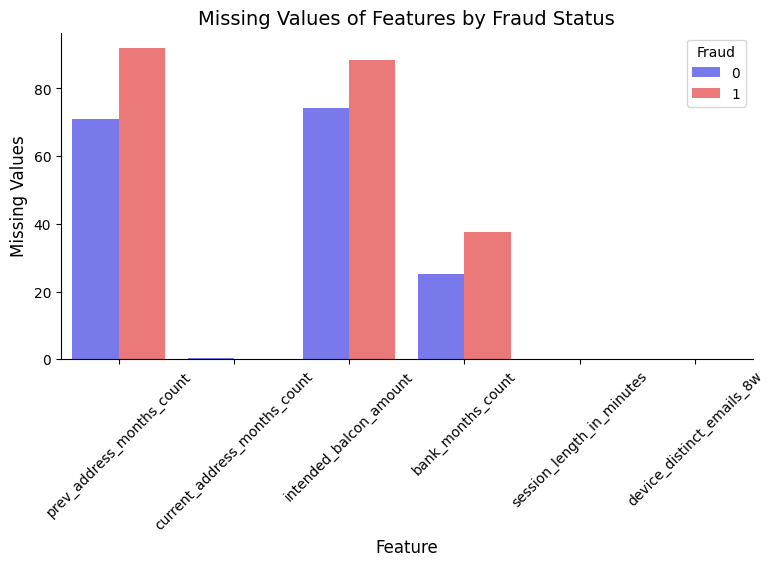

In [30]:
import seaborn as sns

# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.catplot(data=missing_vals, kind="bar", x="feature", y="missing_vals", hue="fraud_bool", alpha=.6, height=4, aspect=2, legend=True, legend_out=False, palette=['blue', 'red'])

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)

# Display plot
plt.show()

When examining features like prev_address_months_count, intended_balcon_amount, and bank_months_count, it becomes apparent that a considerable number of missing values exist in their original distribution. However, despite these missing values, these features still hold informative value and exhibit correlation with the target feature.

## Checking distribution of numeric features

In [31]:
numeric_features = [col for col in df.columns
                    if isinstance(df.schema[col].dataType, NumericType) and df.select(col).distinct().count() >= 10]


print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


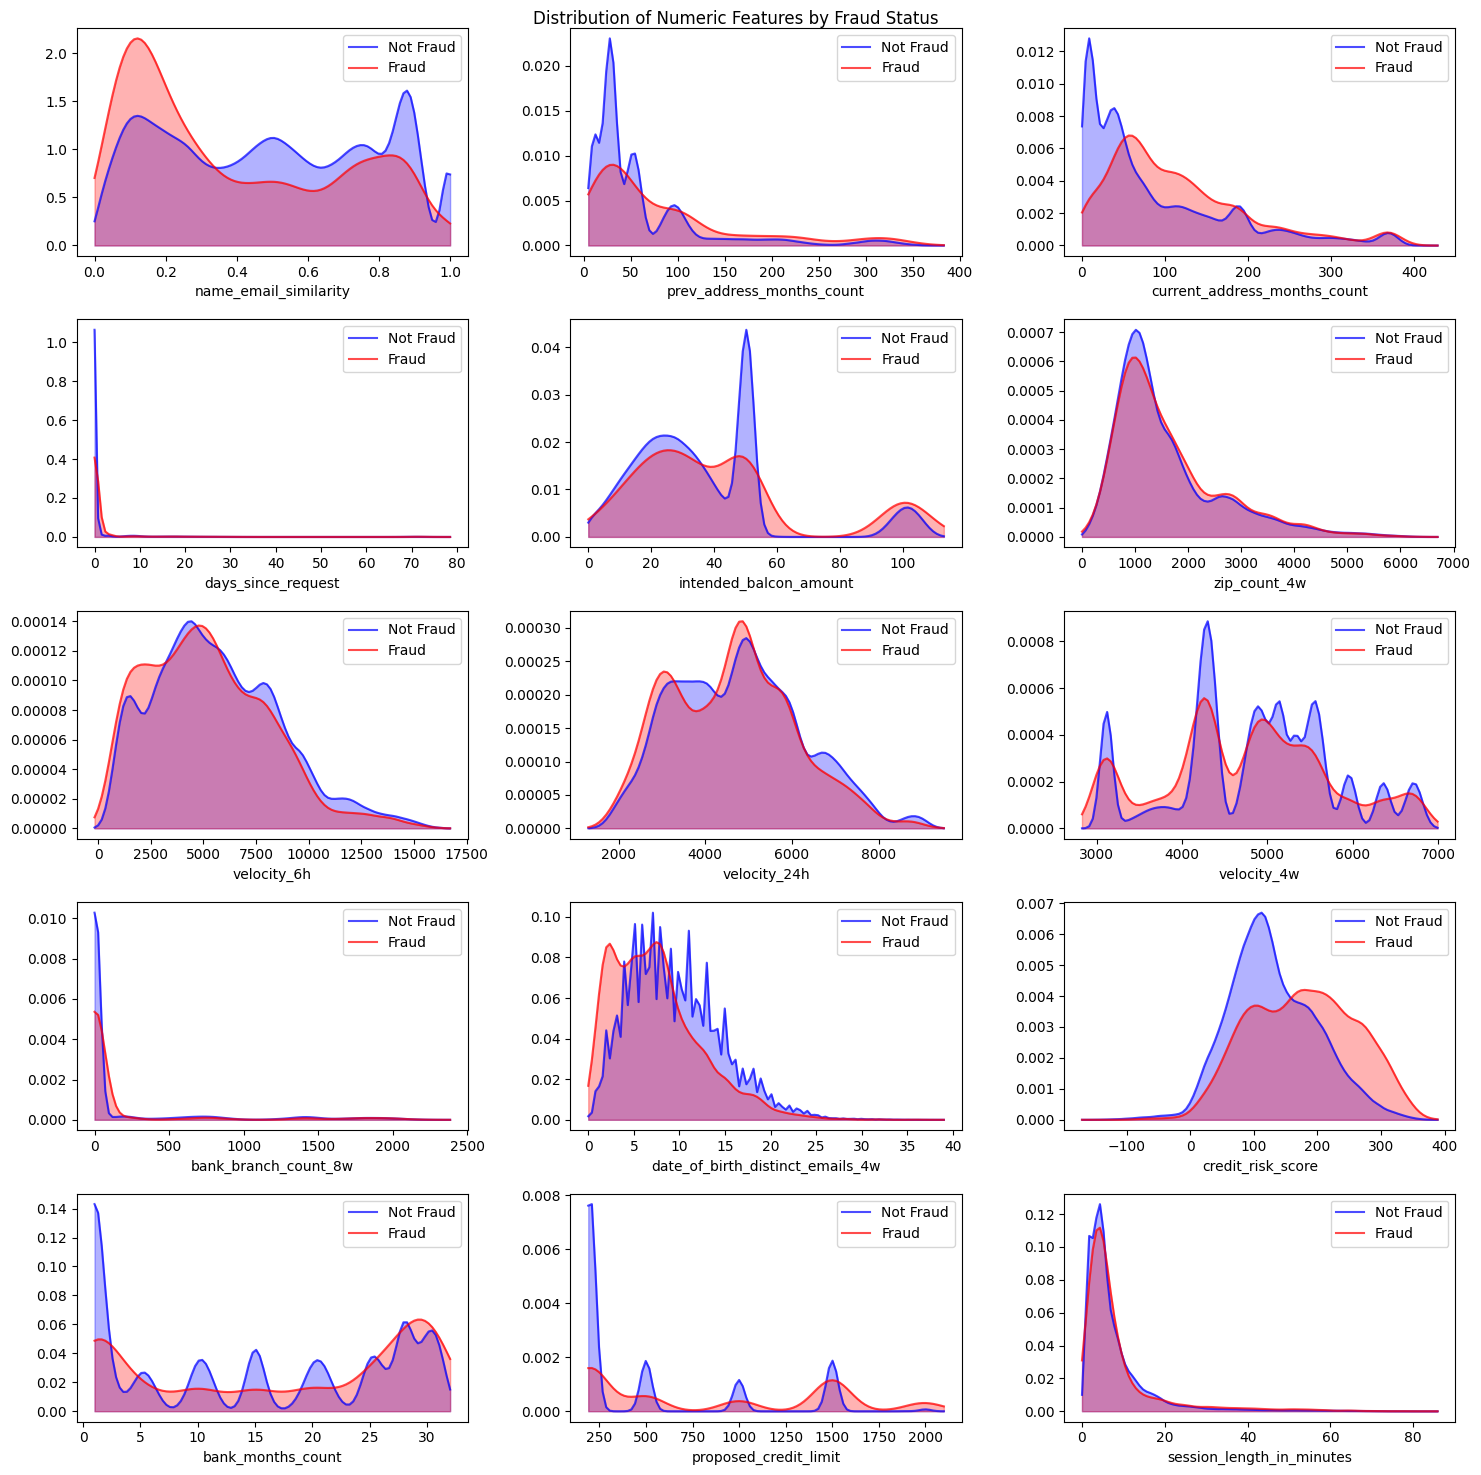

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F
from scipy.stats import gaussian_kde

# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through each feature
for i, feature in enumerate(numeric_features):
    # Extract data for fraudulent and non-fraudulent transactions
    non_fraudulent_data = df.filter(df['fraud_bool'] == 0).select(feature).rdd.flatMap(lambda x: x).collect()
    fraudulent_data = df.filter(df['fraud_bool'] == 1).select(feature).rdd.flatMap(lambda x: x).collect()

    # Remove None (null) values from the data
    non_fraudulent_data = [x for x in non_fraudulent_data if x is not None]
    fraudulent_data = [x for x in fraudulent_data if x is not None]

    # Calculate the KDE for both datasets
    non_fraud_kde = gaussian_kde(non_fraudulent_data)
    fraud_kde = gaussian_kde(fraudulent_data)

    # Generate the x-axis for the plots
    x_min = min(min(non_fraudulent_data), min(fraudulent_data))
    x_max = max(max(non_fraudulent_data), max(fraudulent_data))
    x = np.linspace(x_min, x_max, 100)

    # Plot on the current subplot
    ax = axes[i // 3][i % 3]
    ax.plot(x, non_fraud_kde(x), label='Not Fraud', color='blue', alpha=0.7)
    ax.plot(x, fraud_kde(x), label='Fraud', color='red', alpha=0.7)
    ax.fill_between(x, 0, non_fraud_kde(x), color='blue', alpha=0.3)
    ax.fill_between(x, 0, fraud_kde(x), color='red', alpha=0.3)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

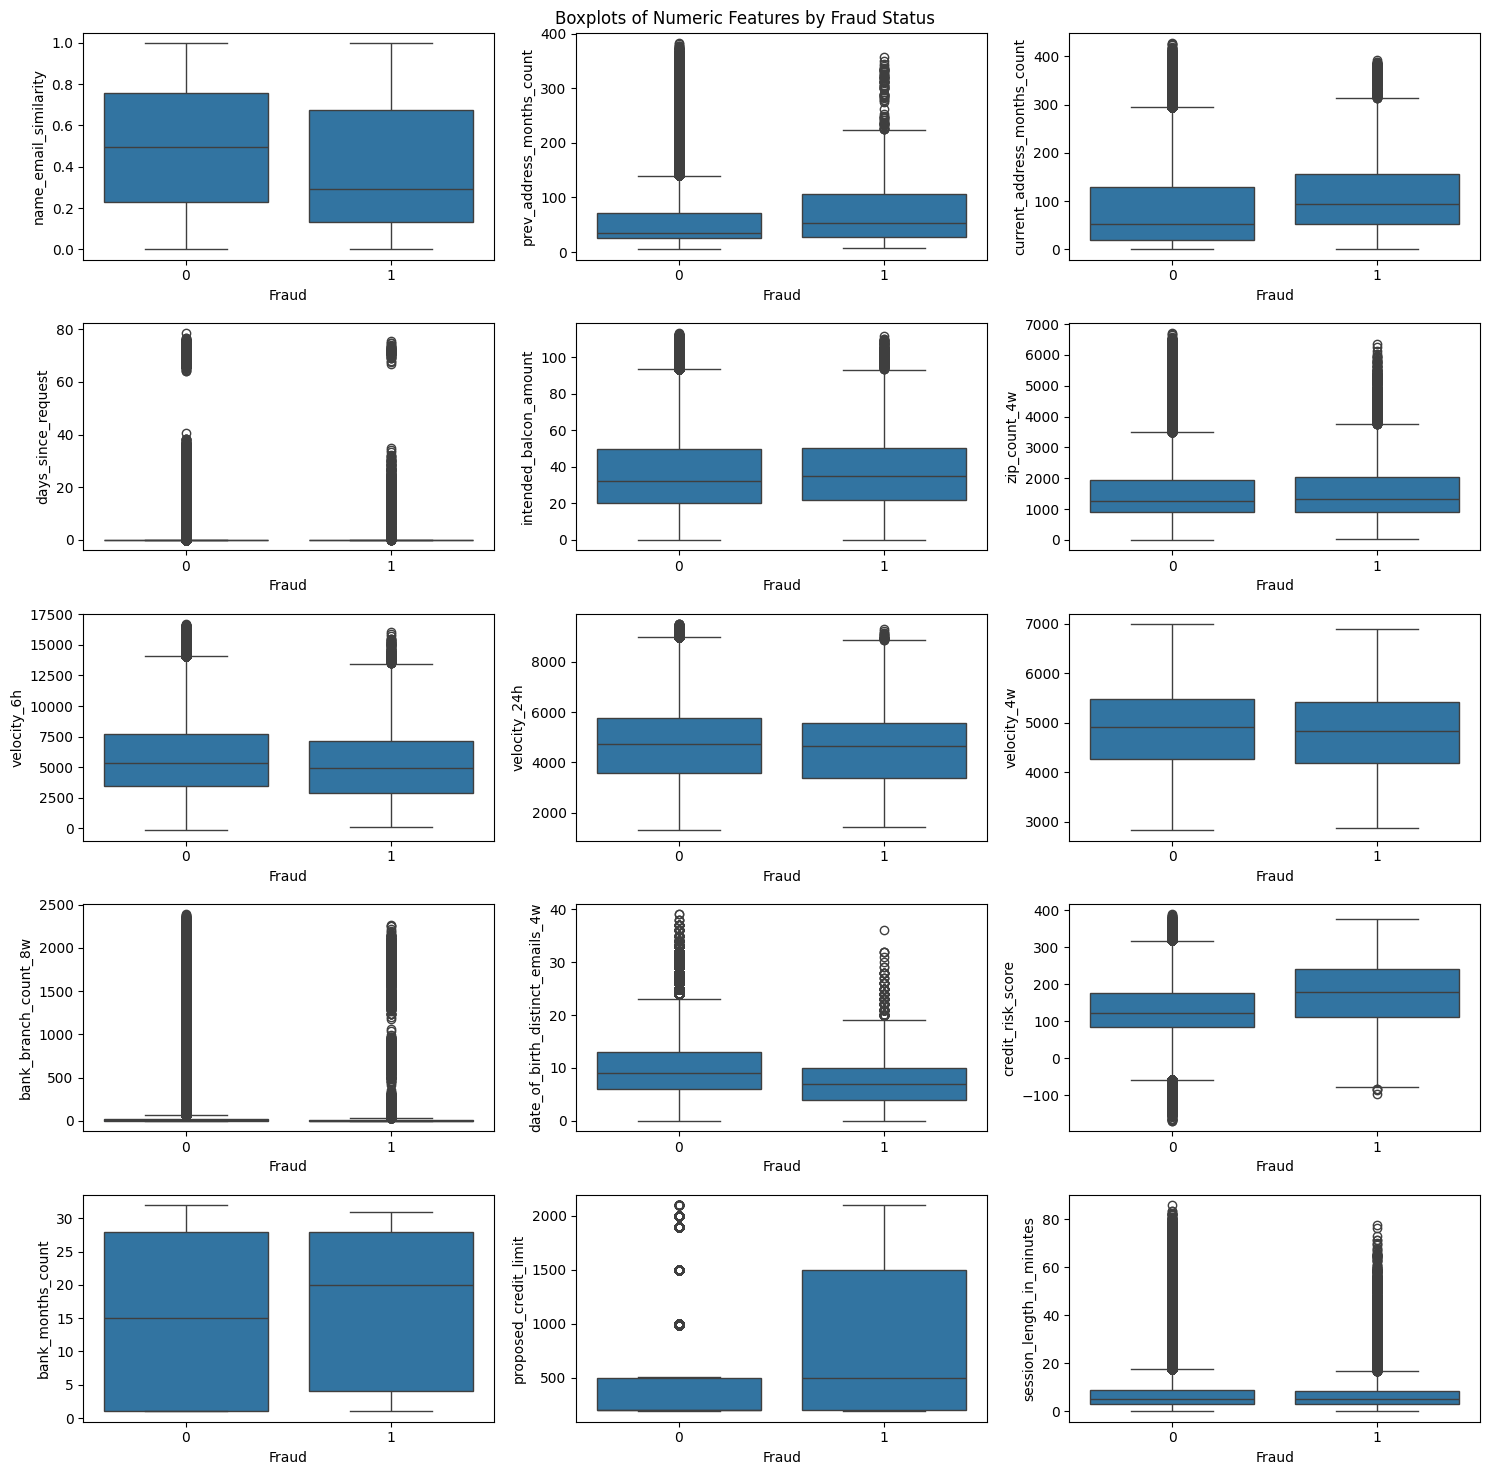

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.suptitle('Boxplots of Numeric Features by Fraud Status')

# Loop through each numeric feature
for i, feature in enumerate(numeric_features):
    if feature in df.columns:  # Check if the column exists
        # Collect data for the boxplot
        feature_data = (
            df.select("fraud_bool", feature)
            .filter(col(feature).isNotNull())
            .rdd.map(lambda row: (row["fraud_bool"], row[feature]))
            .collect()
        )

        # Prepare data for seaborn
        fraud = [row[0] for row in feature_data]
        values = [row[1] for row in feature_data]

        # Create the plot
        ax = axes[i // 3][i % 3]
        sns.boxplot(x=fraud, y=values, ax=ax)
        ax.set_xlabel("Fraud")
        ax.set_ylabel(feature)
    else:
        print(f"Feature '{feature}' does not exist in the DataFrame.")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Checking for frauds in the dataset over time using the month column

In [34]:

# Convert the 'month' column to a string
df = df.withColumn('month', col('month').cast(StringType()))

# Group by month and fraud_bool, count occurrences, and calculate percentage
fraud_by_month = df.groupBy('month', 'fraud_bool').count()

fraud_by_month = fraud_by_month.withColumn('percentage', (col('count') / df.count()) * 100)

fraud_by_month = fraud_by_month.orderBy('month', 'fraud_bool')

fraud_by_month.show()

+-----+----------+------+------------------+
|month|fraud_bool| count|        percentage|
+-----+----------+------+------------------+
|    0|         0|130940|            13.094|
|    0|         1|  1500|              0.15|
|    1|         0|126422|           12.6422|
|    1|         1|  1198|            0.1198|
|    2|         0|135781|13.578100000000001|
|    2|         1|  1198|            0.1198|
|    3|         0|149544|14.954400000000001|
|    3|         1|  1392|            0.1392|
|    4|         0|126239|12.623899999999999|
|    4|         1|  1452|            0.1452|
|    5|         0|117912|           11.7912|
|    5|         1|  1411|            0.1411|
|    6|         0|106718|           10.6718|
|    6|         1|  1450|             0.145|
|    7|         0| 95415|            9.5415|
|    7|         1|  1428|            0.1428|
+-----+----------+------+------------------+



Frauds and non frauds are distributed uniformly over the months.

# Data Preparation Section

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

## Encoding categorical values

In [5]:
# Add _encoded to month column
df = df.withColumnRenamed('month', 'month_encoded')

In [6]:
# Creating a list of the categorical features in the dataset
categorical_variables = [col for col in df.columns
                         if isinstance(df.schema[col].dataType, StringType)]

print(categorical_variables)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


## One-hot encoding the categorical features implementation

It's important to chose only one encoding method this or the one above based on the data and the model that will be used.

In [7]:
# Step 1: Create StringIndexers and OneHotEncoders for each column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_variables]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_variables]

# Step 2: Create a pipeline with both indexers and encoders
pipeline = Pipeline(stages=indexers + encoders)

# Step 3: Fit the pipeline and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Step 4: Select only the new encoded columns, along with other columns if needed
encoded_column_names = [col + "_encoded" for col in categorical_variables]
other_columns = [col for col in df.columns if col not in categorical_variables]  # Get other original columns

df_final = df_encoded.select(*other_columns, *encoded_column_names)

# Show the transformed DataFrame
df_final.show()

24/12/03 17:18:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/12/03 17:18:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_month

## String-Indexing categorical features

In [7]:
# Step 1: Create StringIndexers for each column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_encoded") for col in categorical_variables]

# Step 2: Create a pipeline with only the indexers
pipeline = Pipeline(stages=indexers)

# Step 3: Fit the pipeline and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Step 4: Select the new index columns, along with other columns if needed
indexed_column_names = [col + "_encoded" for col in categorical_variables]
other_columns = [col for col in df.columns if col not in categorical_variables]  # Get other original columns

df_final = df_encoded.select(*other_columns, *indexed_column_names)

# Show the transformed DataFrame
df_final.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_month

24/12/03 17:27:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Min-Max Normalization of numerical features

In [8]:
#Explicitly filter columns that are IntegerType or DoubleType
numerical_features = [
    col for col in df_final.columns
    if isinstance(df_final.schema[col].dataType, (IntegerType, DoubleType))
]

print("Numerical Features:")
print(numerical_features)

Numerical Features:
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month_encoded', 'payment_type_encoded', 'employment_status_encoded', 'housing_status_encoded', 'source_encoded', 'device_os_encoded']


If we chosed string-index as encoding we must remove the categorical columns from the list of numerical features

In [9]:
# Remove from the list all the columns ending with _encoded as they are categorical
numerical_features = [col for col in numerical_features if not col.endswith("_encoded")]

print("Numerical Features (excluding encoded columns):")
print(numerical_features)

Numerical Features (excluding encoded columns):
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count']


In [10]:
#Apply MinMax norm
# Step 2: Assemble these numeric features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_vector")

# Step 3: Apply MinMaxScaler to scale the vector to [0, 1] range
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features_vector")

# Step 4: Apply the assembler and scaler in sequence
df_transformed = assembler.transform(df_final)
df_transformed = scaler.fit(df_transformed).transform(df_transformed)

# Step 5: Convert the scaled vector back into individual columns and overwrite the original columns
df_transformed = df_transformed.withColumn("scaled_features_array", vector_to_array(col("scaled_features_vector")))

# Step 6: Overwrite each original column with its scaled value
for i, feature_name in enumerate(numerical_features):
    df_transformed = df_transformed.withColumn(feature_name, col("scaled_features_array")[i])

# Step 7: Drop intermediate columns to retain only the original set of columns with normalized values
df_transformed = df_transformed.drop("features_vector", "scaled_features_vector", "scaled_features_array")

In [21]:
df_transformed.show()

+----------+-------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid

# Feature selection for classification

## Checking variance of the features and removing zero variance columns

Before calculating Pearson we should remove zero variance columns, because they will have a correlation of 1 with all the other columns, and will also be useless for the classification model and just introduce noise

In [12]:
from pyspark.sql.functions import variance

# Calculate variance for all numerical features
variance_df = df_transformed.select(
    *[variance(col_name).alias(col_name) for col_name in numerical_features]
)

# Collect the variance values
variance_values = variance_df.collect()[0]

# Identify columns with zero variance
zero_variance_cols = [
    col_name for col_name, var in zip(numerical_features, variance_values) if var == 0
]

print("Zero Variance Columns:")
print(zero_variance_cols)

# Drop columns with zero variance
df_transformed = df_transformed.drop(*zero_variance_cols)

Zero Variance Columns:
[]


In [20]:
# drop column device_fraud_count
df_transformed = df_transformed.drop('device_fraud_count')

## Checking Pearson correlation between features to remove highly correlated features

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [23]:
# Use pyspark to calculate the correlation matrix
numerical_features = [
    col for col in df_transformed.columns
    if isinstance(df_transformed.schema[col].dataType, (IntegerType, DoubleType))
]

In [24]:
# Assemble the numerical features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df_vector = assembler.transform(df_transformed)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features", method="pearson").head()[0]

24/12/03 17:43:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/03 17:43:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [14]:
feature_names = df_vector.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names = [attr["name"] for attr in feature_names]

threshold = 0.6
correlated_features = []

for i in range(correlation_matrix.numRows):
    for j in range(i + 1, correlation_matrix.numCols):  # Avoid duplicate pairs and diagonal
        correlation_value = correlation_matrix[i, j]
        if abs(correlation_value) > threshold:
            correlated_features.append((feature_names[i], feature_names[j], correlation_value))

# Step 4: Print the highly correlated features
print("Highly Correlated Features (|correlation| > 0.7):")
for feature1, feature2, value in correlated_features:
    print(f"{feature1} - {feature2}: {value}")

Highly Correlated Features (|correlation| > 0.7):
velocity_4w - month_encoded: -0.8481003026660527
credit_risk_score - proposed_credit_limit: 0.6061414475226944


I think we will need to remove month from the dataset during the classification (its also categorical) and has high correlation with velocity_4w. Only that feature, because we don't have other highly correlated features.

# Saving the preprocessed data

In [25]:
#Save a csv file with the preprocessed data
df_transformed.coalesce(1).write.csv('/Users/savato/Data Science/ddam/dataset/PreprocessedDataStringIndexed.csv', header=True, mode='overwrite')

Sadly methods like NearMiss and TomekLinks are not implemented in PySpark, so we will have to use the undersampling method.